# Non-diffractive 2D tomographic simulations

This code simulate the non-diffracting tomographic reconstruction of an object using filtered backprojection and Fourier interpolation. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
from time import time
from mpl_toolkits import mplot3d
from IPython.display import display, Latex
from skimage.transform import radon, rescale, iradon
from scipy.interpolate import griddata
from scipy.ndimage import rotate

<img align="right" src="2dtomographygeometry.png" width="400">

We set up a cylindrically shaped object and calculate with analytical theory the parallel beam projection. Here we will use the equations of Kak and Slaney (Kak and Slaney, Principles of computerized tomographic imaging, IEEE press, page 54). The width of the object $a^2$ is
\begin{equation}
    a^2(\theta)= A^2 \cos^2\theta+ B^2 \sin^2 \theta
\end{equation}
for varying detector angle $\theta$. Consequently, the projection is
\begin{equation}
    P_{\theta}(t)=\frac{2\rho A B}{a^2(\theta)}\sqrt{a^2(\theta) - t^2}
\end{equation}
with $t$ the lateral detector position and $\rho$ the density to be reconstructed. Note that $P_\theta(0)$ is equal to two times the major axis length. The angle $\theta=0$ corresponds to a projection in the $y$-axis direction with the detector plane oriented along the $x$-axis.




In [2]:
nproj=128                                   # number of projections
L=10e-3                                     # 10 mm object field of view
N=128                                       # number of pixels of the object
a=1.5e-3
b=2e-3                                      # diameter of the cylinder
rho=1000

# set up the detector coordinates and frequencies
deltax = L/N
x=deltax*np.linspace(-N/2, (N/2)-1, N)
y=x
t=x
fx=np.linspace(-1/2/deltax, 1/2/deltax-1/L, N)
[xx,yy] = np.meshgrid(x,x)
[Fx,Fy] = np.meshgrid(fx,fx)

# define the object
object = 1.0*rho*((xx/a)**2 + (yy/b)**2<= 1)
objectFT = np.real(deltax**2*np.fft.fftshift(np.fft.fft2(np.fft.fftshift(object))))

# define the projection
theta=0
a2theta=(a**2*np.cos(theta)**2+b**2*np.sin(theta)**2)
ind=1.0*(a2theta - t**2 > 0)
projection=2*rho*a*b*np.sqrt(ind*(a2theta - t**2))/a2theta             

projectionFT = np.real(deltax*np.fft.fftshift(np.fft.fft(np.fft.fftshift(projection))))


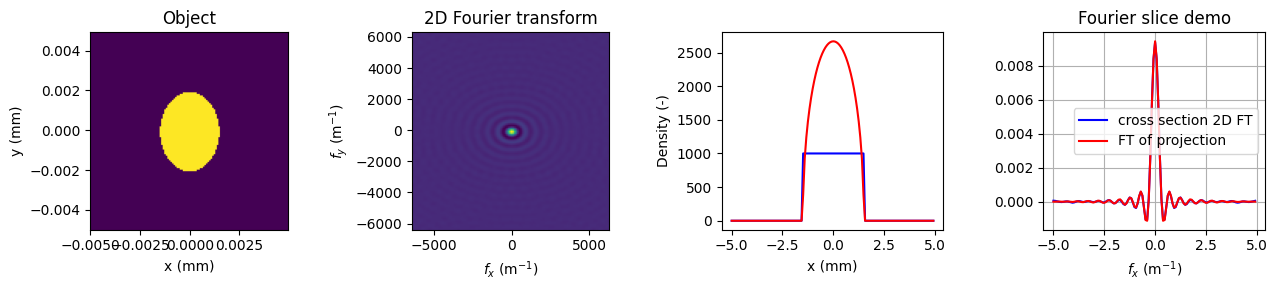

In [3]:
fig = plt.figure(figsize=[13,3])

plt.subplot(141)
plt.imshow(object, extent=[x[0], x[-1], y[0], y[-1]])
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Object')

plt.subplot(142)
plt.imshow(objectFT.real, extent=[fx[0], fx[-1], fx[0], fx[-1]])
plt.xlabel(r'$f_x$ (m$^{-1}$)')
plt.ylabel(r'$f_y$ (m$^{-1}$)')
plt.title('2D Fourier transform')

plt.subplot(143)
plt.plot(1e3*x, object[int(N/2),:], '-b', label='object')
plt.plot(1e3*x, projection/a, '-r', label='projection') # added factor a just for plotting
plt.xlabel('x (mm)'), plt.ylabel('Density (-)')

plt.subplot(144)
plt.plot(1e3*x, objectFT[int(N/2),:], '-b', label='cross section 2D FT')
plt.plot(1e3*x, projectionFT, '-r', label='FT of projection')
plt.xlabel('$f_x$ (m$^{-1}$)')
plt.legend(), plt.grid(), plt.title('Fourier slice demo')
plt.tight_layout()

The next step is to generate all Fourier-domain data. We Fourier transform the projection and duplicate the data to fill up Fourier space.

In [4]:
# set up the angles of the projections
theta=np.linspace(0,2*np.pi, nproj, endpoint=False)

# set up the radial frequencies
fr=fx

# set up data arrays
datafx=np.zeros([nproj,N])
datafy=np.zeros([nproj,N])
sinogram=np.zeros([N, nproj])
dataFT=np.zeros([nproj,N])

for cnt in range(nproj):
    fxpol=np.cos(theta[cnt])*fr
    fypol=np.sin(theta[cnt])*fr
    datafx[cnt,:]=fxpol
    datafy[cnt,:]=fypol
    
    a2theta=(a**2*np.cos(theta[cnt])**2+b**2*np.sin(theta[cnt])**2)
    ind=1.0*(a2theta - t**2 > 0)
    projection=2*rho*a*b*np.sqrt(ind*(a2theta - t**2))/a2theta
    sinogram[:,cnt]=projection
    dataFT[cnt,:]=np.real(deltax*np.fft.fftshift(np.fft.fft(np.fft.fftshift(projection))))

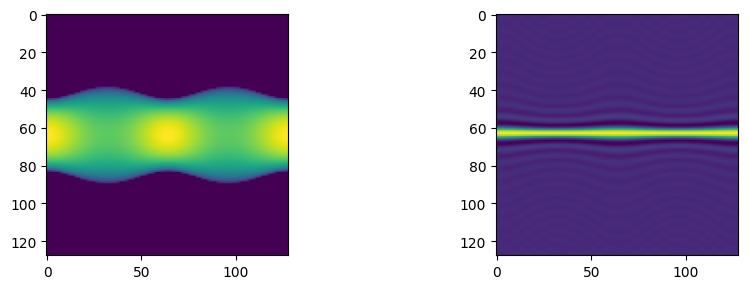

In [5]:
fig = plt.figure(figsize=[10,3])

plt.subplot(121)
plt.title('')
plt.imshow(sinogram)


plt.subplot(122)
plt.title('')
plt.imshow(np.rot90(dataFT))

plt.tight_layout()

Text(0.5, 0, 'Amplitude')

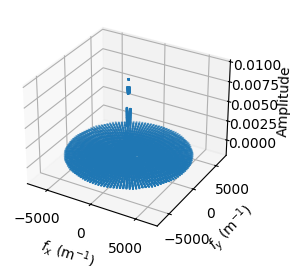

In [6]:
fig = plt.figure(figsize = (3, 3))
spec = fig.add_gridspec(1, 2)

ax = fig.add_subplot(projection='3d')
size=0.2*np.ones([nproj,N])
# Create Plot
ax.scatter(datafx, datafy, dataFT, marker='x', s=size)
ax.set_xlabel('$f_x$ (m$^{-1}$)')
ax.set_ylabel('$f_y$ (m$^{-1}$)')
ax.set_zlabel('Amplitude')


From all the data the FBP and Fourier-domain interpolation is implemented and compared.

In [7]:
# fbp reconstruction
start=time()
reconstruction_fbp = (1/deltax)*iradon(sinogram, theta=360*theta/2/np.pi, circle=True, interpolation='linear', output_size=N)
end=time()

print('The time for backprojection ' + str(N) + ' times ' + str(N) + ' pixels is ' + str(round(end-start,6)) + ' seconds')

# interpolation reconstruction
datafxinterp=np.reshape(datafx, (nproj*N,1))
datafyinterp=np.reshape(datafy, (nproj*N,1))
dataFTinterp=np.reshape(dataFT, (nproj*N,1))

points=np.zeros([nproj*N,2])
points[:,0]=np.squeeze(datafxinterp)
points[:,1]=np.squeeze(datafyinterp)

frmax=1.5*np.max(fr)
index=((Fx**2+Fy**2)<frmax**2)

start=time()
dataFTcart = np.squeeze(griddata(points, dataFTinterp, (Fx, Fy), method='cubic'))
end=time()
print('The time for interpolation of ' + str(N) + ' times ' + str(N) + ' pixels is ' + str(round(end-start,6)) + ' seconds')

dataFTcart[np.where(np.isnan(dataFTcart))] = 0
          
start=time()
objectinterp = np.squeeze(np.real(deltax**(-2)*np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(dataFTcart)))))
end=time()

print('The time for calculating the Fourier transform for ' + str(N) + ' times ' + str(N) + ' pixels is ' + str(round(end-start,9)) + ' seconds')

The time for backprojection 128 times 128 pixels is 0.01743 seconds
The time for interpolation of 128 times 128 pixels is 0.128615 seconds
The time for calculating the Fourier transform for 128 times 128 pixels is 0.000390291 seconds


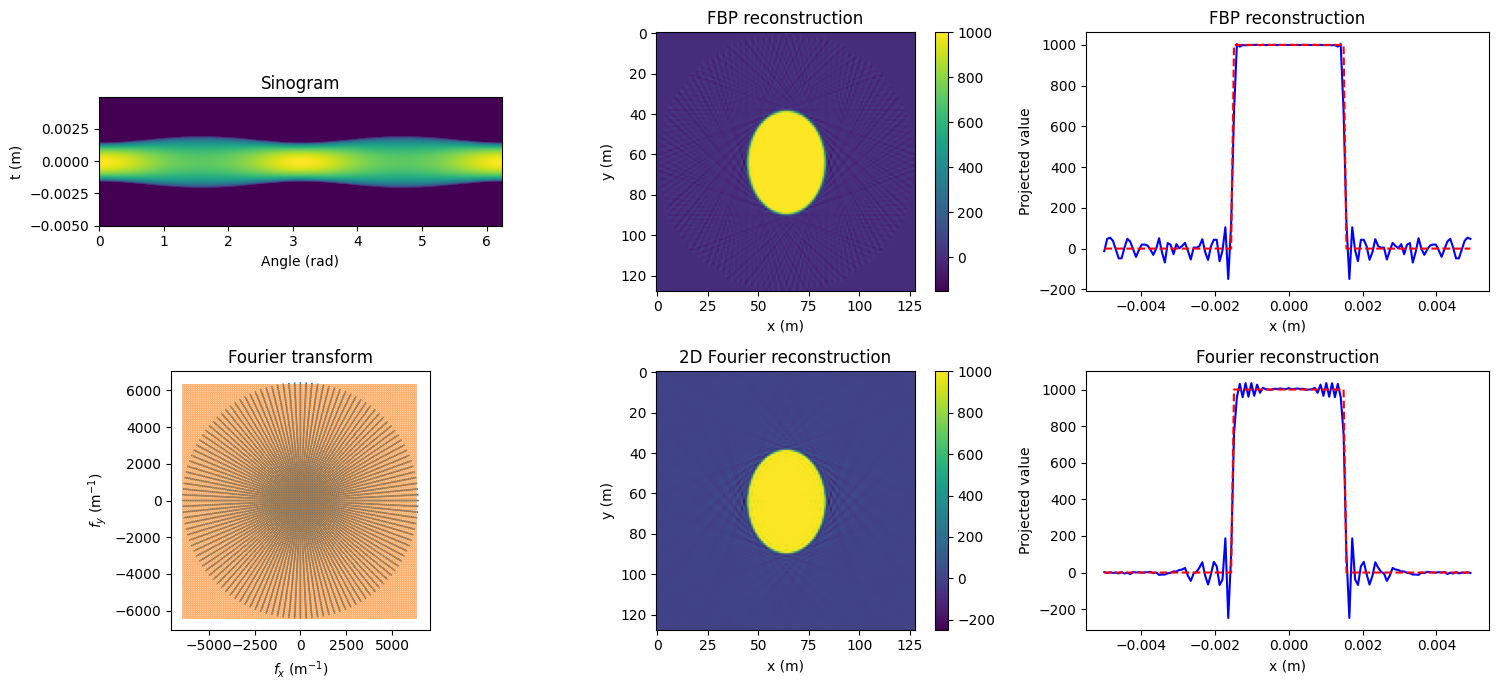

In [8]:
fig = plt.figure(figsize=[15,7])
ax1 = fig.add_subplot(2, 3, 1)
ax1.imshow(sinogram, extent=[theta[0], theta[-1], x[0], x[-1]])
ax1.set_xlabel('Angle (rad)')
ax1.set_ylabel('t (m)')
ax1.set_aspect(200)
ax1.set_title('Sinogram')

ax2 = fig.add_subplot(2, 3, 2)
rec=ax2.imshow(reconstruction_fbp, vmax=rho)
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
ax2.set_title('FBP reconstruction')
fig.colorbar(rec, ax=ax2)

ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(x, reconstruction_fbp[int(N/2), :], '-b')
ax3.plot(x, object[int(N/2),:], '--r')
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
ax3.set_ylabel('Projected value')
ax3.set_title('FBP reconstruction')

ax4 = fig.add_subplot(2, 3, 4)
ax4.set_xlabel(r'$f_x$ (m$^{-1}$)')
ax4.set_ylabel(r'$f_y$ (m$^{-1}$)')
ax4.set_title('2D Fourier transform')
size=0.1*np.ones(np.size(datafx))
ax4.scatter(datafx, datafy, marker='x', s=size)         # these are the polar coordinates
size=0.1*np.ones(np.size(Fx[index]))
ax4.scatter(Fx[index], Fy[index], marker='o', s=size)   # these are the cartesian coordinates
ax4.set_title('Fourier transform')
ax4.set_aspect(1)

ax5 = fig.add_subplot(2, 3, 5)
rec=ax5.imshow(np.real(objectinterp), vmax=rho)
ax5.set_xlabel('x (m)')
ax5.set_ylabel('y (m)')
ax5.set_title('2D Fourier reconstruction')
fig.colorbar(rec, ax=ax5)

ax6 = fig.add_subplot(2, 3, 6)
ax6.plot(x, objectinterp[int(N/2), :], '-b')
ax6.plot(x, object[int(N/2),:], '--r')
ax6.set_xlabel('x (m)')
ax6.set_ylabel('Projected value')
ax6.set_title('Fourier reconstruction')

plt.tight_layout()

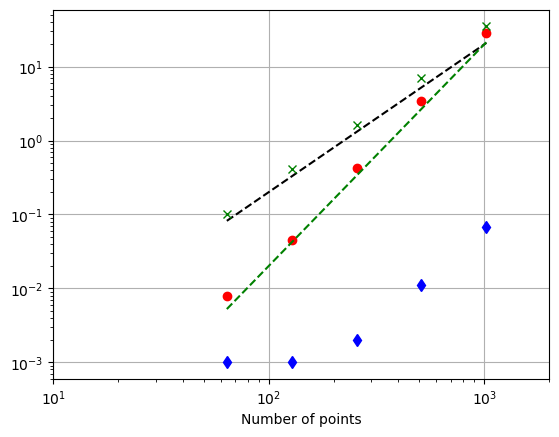

In [38]:
Nt=np.array([64,128, 256, 512, 1024])

timefbp=np.array([0.007979,0.044891, 0.424894, 3.38213, 28.375272])

timeinterpol=np.array([0.100216,0.409548, 1.618598, 6.974965, 35.167982])

time2dFT=np.array([0.001019478, 0.000997066, 0.001992, 0.01097, 0.067142487])

# timing with cubic interpolation
plt.loglog(Nt, timefbp, 'or')
plt.loglog(Nt, 0.2e-4*Nt**2, '--k')
plt.loglog(Nt, timeinterpol, 'xg')
plt.loglog(Nt, 0.2e-7*Nt**3, '--g')
plt.loglog(Nt, time2dFT, 'db')
plt.xlabel('Number of points')
plt.xlim([10, 2000])
plt.grid()

The iradon toolbox options can be found at

https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.iradon